Here we want to start testing out how to use ML methods to identify the true CBs, inspired by the DropEst BioRxiv manuscript. We can get most of the information we require from the 10X BAM file, namely:

DropEst metrics:
1. Mean # reads per UMI
2. Mean # UMIs per gene
3. Fraction low-expressed genes (1 read per gene)
4. Fraction of UMIs on low-expressed genes
5. Fraction of Integenic reads
6. Fraction of non-aligned reads

We also want to add:
7. Fraction of non-genic reads (Since this is what we will be able to obatin in alevin)
8. Fraction of Mt reads (This was previously just used as a hard threshold. We want to see whether it's useful to include in ML)
9. Duplication rate (Not used in DropEst)
10. Some measure(s) of expression distribution
11. Mean CB quality
12. Max correlation with true cells


EDIT: Note that not all the above metrics are now used. The first 1-6 are no longer used

In [1]:
import pyximport
pyximport.install(reload_support=True)
from umi_tools._dedup_umi import edit_distance
import umi_tools.umi_methods as umi_methods
import umi_tools.Utilities as U
import collections
import pandas as pd
import numpy as np
import scipy
import pysam
import regex
import glob
import CGAT.Fastq as Fastq
import CGAT.IOTools as IOTools
from datetime import datetime
%load_ext rpy2.ipython
%matplotlib inline  

In [2]:
from pandas.tools.plotting import scatter_matrix
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

BAM infile:
* All reads (no CBs filtered out)
* CB and UMI extracted
* Aligned to combined human and mouse genomes (contig names prefixed with "hg" and "mm", respectively)
* Genes assigned (featureCounts)

In [3]:
bam_infile = "/home/FILESERVER5/proteomics/tss38/ifs/projects/toms/cell_barcode/run/mapped/hgmm_1k_extracted.bam.featureCounts.bam"

In [4]:
def getCounterMeanPhred(counter):
    '''
    Return the mean error rate from a counter of error rates on a Phred scale
    
    To get the mean error rate, need to convert Phred back into an actual probability
    '''
    
    sum_prob = 0
    total_count = 0
    for number, count in counter.most_common():
        prob = 10**(number/(-10))
        sum_prob += (prob*count)
        total_count += count
    mean = sum_prob/total_count
    
    return mean 

Here we parse the input BAM and tally read events, e.g reads per CB

In [5]:
def phredToInt(phreds):
    return(list(map(lambda x: ord(x)-33, phreds)))

qualities = collections.defaultdict(collections.Counter)

genome2reads = collections.Counter()
cell_umi_counts = collections.defaultdict(lambda: collections.defaultdict(lambda: collections.Counter()))
cell_counts = collections.Counter()
cell_gene_counts = collections.defaultdict(lambda: collections.Counter())
cell2species = collections.defaultdict(collections.Counter)
inbam = pysam.Samfile(bam_infile)
cell_counts_mapped = collections.defaultdict(collections.Counter)
contigs = set()

n = 0
for read in inbam.fetch(until_eof=True):
    
    umi, cell = [x.decode() for x in umi_methods.get_barcode_read_id(read, cell_barcode=True)]
    
    if read.is_secondary:
        continue
    
    if read.is_unmapped:
        cell_counts_mapped[cell]['unmapped'] += 1
    else:
        cell_counts_mapped[cell]['mapped'] += 1
        
        species = read.reference_name.split("_")[0]
        contig = "_".join(read.reference_name.split("_")[1:])
        contigs.add(contig)
        genome2reads[species] += 1
        
        if contig.startswith("chrM"):
            cell_counts_mapped[cell]['Mt'] += 1
        try:
            gene = read.get_tag("XT")
            cell_gene_counts[cell][gene] +=1
            cell_umi_counts[cell][gene][umi] += 1
        except KeyError:
            pass # no gene assigned

        cell2species[cell][species] += 1
    
    cell_counts[cell] += 1
    qualities[cell].update(read.query_qualities)
    
    n+=1
    
    if n % 1000000 == 0:
        print("processed %iM reads %s" % (
            (float(n)/1000000), datetime.now().strftime('%Y-%m-%d %H:%M:%S')))
    
    #if n > 1000000: # for testing
    #    break

    




processed 1M reads 2017-10-05 17:47:58
processed 2M reads 2017-10-05 17:48:22
processed 3M reads 2017-10-05 17:48:48
processed 4M reads 2017-10-05 17:49:13
processed 5M reads 2017-10-05 17:49:39
processed 6M reads 2017-10-05 17:50:03
processed 7M reads 2017-10-05 17:50:28
processed 8M reads 2017-10-05 17:50:51
processed 9M reads 2017-10-05 17:51:16
processed 10M reads 2017-10-05 17:51:39
processed 11M reads 2017-10-05 17:52:04
processed 12M reads 2017-10-05 17:52:31
processed 13M reads 2017-10-05 17:52:55
processed 14M reads 2017-10-05 17:53:19
processed 15M reads 2017-10-05 17:53:42
processed 16M reads 2017-10-05 17:54:08
processed 17M reads 2017-10-05 17:54:32
processed 18M reads 2017-10-05 17:54:56
processed 19M reads 2017-10-05 17:55:21
processed 20M reads 2017-10-05 17:55:45
processed 21M reads 2017-10-05 17:56:11
processed 22M reads 2017-10-05 17:56:35
processed 23M reads 2017-10-05 17:56:59
processed 24M reads 2017-10-05 17:57:23
processed 25M reads 2017-10-05 17:57:48
processed

Now we convert the tallies into the various metrics we want to use to train the ML methods

In [6]:
rows = []
n = 0
for cell in cell_counts:
    reads = cell_counts[cell]
    
    if reads < 100:
        continue
    
    mapped = cell_counts_mapped[cell]['mapped']

    if mapped == 0:
        continue

    unmapped = cell_counts_mapped[cell]['unmapped']
    assigned = sum(list(cell_gene_counts[cell].values()))
    mt_reads = cell_counts_mapped[cell]['Mt']
    genes = len(cell_gene_counts[cell])
    dedup_reads = sum([len(x) for x in cell_umi_counts[cell].values()])
    
    if assigned > 0:
        mean_reads_per_umi = np.mean([cell_umi_counts[cell][gene][umi] for gene in cell_umi_counts[cell]
             for umi in cell_umi_counts[cell][gene]])
    
        ratio_mean_max = mean_reads_per_umi/max(
            [cell_umi_counts[cell][gene][umi] for gene in cell_umi_counts[cell]
                 for umi in cell_umi_counts[cell][gene]])
        assigned_fraction = assigned/mapped
    
    else:
        mean_reads_per_umi = 0
        ratio_mean_max = 0
        assigned_fraction = 0

    aligned_fraction = mapped/reads
    
    mt_fraction = mt_reads/mapped
    duplication_rate = 1-(dedup_reads/mapped)

    mean_qual = getCounterMeanPhred(qualities[cell])
    
    hg_reads = cell2species[cell]["hg"]
    mm_reads = cell2species[cell]["mm"]
    specificity = max((hg_reads, mm_reads))/(hg_reads + mm_reads)

    exp_counts = list(cell_gene_counts[cell].values())

    if len(exp_counts) > 0:
        mean_exp = np.mean(exp_counts)
        try:
            over_mean_exp = len([x for x in list(cell_gene_counts[cell].values()) if x > mean_exp])/genes
        except:
            print(genes)
            print(mean_exp)
            print(mean_exp == np.nan)
            raise ValueError()
    else:
        mean_exp = 0
        over_mean_exp = 0
    
    rows.append((cell, reads, aligned_fraction, assigned_fraction, mt_fraction,
                 duplication_rate, mean_reads_per_umi, ratio_mean_max, mean_qual,
                 over_mean_exp, mean_exp, genes, specificity))
    n+=1
    if n<5:
        print(cell, reads, aligned_fraction, assigned_fraction, mt_fraction,
              duplication_rate, mean_reads_per_umi, ratio_mean_max, mean_qual,
              over_mean_exp, mean_exp, genes, specificity)
    #else:
    #    break

CGGCACAGCTGAACGT 159 0.7484276729559748 0.6554621848739496 0.03361344537815126 0.5126050420168067 1.34482758621 0.448275862069 0.005995484255258125 0.32075471698113206 1.47169811321 53 1.0
CATTCGCTCGTTACAG 134 0.8208955223880597 0.8272727272727273 0.0 0.44545454545454544 1.49180327869 0.298360655738 0.006032574262110458 0.4107142857142857 1.625 56 0.7090909090909091
AGCTCTCTCACTGGGC 49108 0.8018245499714914 0.6092543681430312 0.04639882161722877 0.5365197074360016 1.31452054795 0.219086757991 0.004598855484133709 0.16941228851291185 5.34060552093 4492 0.9951239333604226
GAAAGCAGTCAAGCGA 151 0.8543046357615894 0.689922480620155 0.0 0.4728682170542635 1.30882352941 0.436274509804 0.004884900659891765 0.3492063492063492 1.4126984127 63 0.9922480620155039


In [7]:
def checkError(barcode, whitelist):
    near_matches = set()
    comp_regex = regex.compile("(%s){e<=1}" % barcode)
    comp_regex2 = regex.compile("(%s){e<=1}" % barcode[:-1])
    b_length = len(barcode)
    for whitelisted_barcode in whitelist:
        w_length = len(whitelisted_barcode)
        if barcode == whitelisted_barcode:
            continue
        if (max(b_length, w_length) > (min(b_length, w_length) + 1)):
            continue
        if comp_regex.match(whitelisted_barcode) or comp_regex2.match(whitelisted_barcode):
            near_matches.add(whitelisted_barcode)
            if len(near_matches) > 1:
                return near_matches

    return near_matches

Below we:

1. Convert into a dataframe
2. standardise the metrics to [0-1]
3. group CBs into:
    * "true_cell" = the top 500 CBs
    * "pos_true_cell" & "pos_true_cell2" = the next 1000 CBs split into two 500 CB groups
    * "false_cell" = the rest

We'll use the "true_cell" and "false_cell" to train the model and then classify the 1000 CBs between true and false

In [8]:
df = pd.DataFrame.from_records(rows, columns=[
    "cell", "reads", "aligned", "assigned", "mt", "dup_rate", "mean_reads_umi",
    "ratio_mean_max", "mean_qual", "over_mean_exp", "mean_exp", "genes", "specificity"])

df.set_index("cell", inplace=True)

print(df.head())

for col in ["aligned", "assigned", "mt", "dup_rate", "mean_reads_umi",
            "ratio_mean_max", "mean_qual", "over_mean_exp", "mean_exp", "genes"]:
    max_col = max(df[col])
    df[col] = df[col]/max_col


sorted_df = df.sort_values("reads", ascending=False)
true_cells = sorted_df.ix[0:500].index
pos_true_cells = sorted_df.ix[500:1000].index
pos_true_cells2 = sorted_df.ix[1000:1500].index

cell_type = []
for x in df.index:
    if x in true_cells:
        cell_type.append("true_cell")
    elif x in pos_true_cells:
        cell_type.append("pos_true_cell")
    elif x in pos_true_cells2:
        cell_type.append("pos_true_cell2")
    else:
        cell_type.append("false cell")

#df['top_cell'] = [x in top_100_cells for x in df.index]
df['cell_type'] = cell_type

df['error'] = [len(checkError(x, true_cells))>0 for x in df.index]      

print(df.head())

                  reads   aligned  assigned        mt  dup_rate  \
cell                                                              
CGGCACAGCTGAACGT    159  0.748428  0.655462  0.033613  0.512605   
CATTCGCTCGTTACAG    134  0.820896  0.827273  0.000000  0.445455   
AGCTCTCTCACTGGGC  49108  0.801825  0.609254  0.046399  0.536520   
GAAAGCAGTCAAGCGA    151  0.854305  0.689922  0.000000  0.472868   
CTCATTAAGAGACTAT    110  0.718182  0.696203  0.012658  0.443038   

                  mean_reads_umi  ratio_mean_max  mean_qual  over_mean_exp  \
cell                                                                         
CGGCACAGCTGAACGT        1.344828        0.448276   0.005995       0.320755   
CATTCGCTCGTTACAG        1.491803        0.298361   0.006033       0.410714   
AGCTCTCTCACTGGGC        1.314521        0.219087   0.004599       0.169412   
GAAAGCAGTCAAGCGA        1.308824        0.436275   0.004885       0.349206   
CTCATTAAGAGACTAT        1.250000        0.416667   0.004636   

Next we derive the maximum (Spearman's) correlation between each cell and the true cells

In [9]:
all_genes = set()
for cell in cell_counts.keys():
    genes = set(cell_umi_counts[cell].keys())
    all_genes.update(genes)
print(len(all_genes))

28368


In [10]:
true_cell_arrays = {}
for cell in true_cells:
    gene_exp_array = [len(cell_umi_counts[cell][x]) for x in all_genes]
    true_cell_arrays[cell] = gene_exp_array

Let's check whether we could just store the pre-computed ranks since this will save a lot of runtime for the correlations

In [11]:
t1 = list(true_cells)[0]
t2 = list(true_cells)[1]
print(scipy.stats.spearmanr(true_cell_arrays[t1], true_cell_arrays[t2]))
print(scipy.stats.pearsonr(scipy.stats.rankdata(true_cell_arrays[t1]),
                           scipy.stats.rankdata(true_cell_arrays[t2])))

SpearmanrResult(correlation=0.73976825581580175, pvalue=0.0)
(0.73976825581580186, 0.0)


So this appears to work, let's re-obtain the expression data for the true cells and compute the ranks. We'll also derive the average ranking at the same time

In [246]:
true_cell_arrays = {}
for cell in true_cells:
    gene_exp_array = scipy.stats.rankdata([len(cell_umi_counts[cell][x]) for x in all_genes])
    true_cell_arrays[cell] = gene_exp_array
    
average_cell_array = []
for gene in all_genes:
    average_cell_array.append(np.mean([len(cell_umi_counts[cell][gene]) for cell in true_cells]))

average_cell_array = scipy.stats.rankdata(average_cell_array)

ranks_df = pd.DataFrame.from_records(true_cell_arrays)

Now we need to calculate the max correlation for each cell relative to the true cells. let's see which approach is fastest for this

In [49]:
%%timeit
max_cor = -1
for true_cell in true_cells:
    cor = scipy.stats.pearsonr(cell_exp_array, true_cell_arrays[true_cell])[0]
    if cor > max_cor:
        max_cor = cor


66.4 ms ± 1.99 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [17]:
cell_exp_series = pd.Series(cell_exp_array)

In [50]:
%%timeit
max_cor2 = max(ranks_df.apply(lambda x: x.corr(cell_exp_series)))

178 ms ± 17.8 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [51]:
%%timeit
max_cor3 = max(ranks_df.corrwith(cell_exp_series))

171 ms ± 12.2 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [52]:
max_cor = -1
for true_cell in true_cells:
    cor = scipy.stats.pearsonr(cell_exp_array, true_cell_arrays[true_cell])[0]
    if cor > max_cor:
        max_cor = cor
        
cell_exp_series = pd.Series(cell_exp_array)
max_cor2 = max(ranks_df.apply(lambda x: x.corr(cell_exp_series)))

max_cor3 = max(ranks_df.corrwith(cell_exp_series))

print(max_cor)
print(max_cor2)
print(max_cor3)

0.108432294912
0.108432294912
0.108432294912


OK, so all approaches give the same answer (phew!). It appears the for loop is the fastest (unexpected) but this still takes ~70ms for just 1 cell. 

In [250]:
n = 0
cor_with_true = []
ninth_dec_cor_with_true = []
eighth_dec_cor_with_true = []
seventh_dec_cor_with_true = []
cor_with_average = []
for cell in df.index:
    cell_exp_array = []
    # check for gene first rather than simply calling cell_umi_counts[cell][gene], otherwise 
    # cell_umi_counts becomes MASSIVELY inflated with zero counts!!
    for gene in all_genes: 
        if gene in cell_umi_counts[cell]:
            cell_exp_array.append(len(cell_umi_counts[cell][gene]))
        else:
            cell_exp_array.append(0)
    
    if max(cell_exp_array) == 0:
        cor_with_true.append(0)
        ninth_dec_cor_with_true.append(0)
        eighth_dec_cor_with_true.append(0)
        seventh_dec_cor_with_true.append(0)
        cor_with_average.append(0)
        continue
    
    cell_exp_array = scipy.stats.rankdata(cell_exp_array)
    
    max_cor = -1
    cor_values = []
    for true_cell in true_cells:
        if true_cell == cell: # skip correlation with itself!
            continue
        cor = scipy.stats.pearsonr(cell_exp_array, true_cell_arrays[true_cell])[0]
        cor_values.append(cor)
        if cor > max_cor:
            max_cor = cor
    
    cor_with_true.append(max_cor)
    ninth_dec_cor_with_true.append(np.percentile(cor_values, 90))
    eighth_dec_cor_with_true.append(np.percentile(cor_values, 80))
    seventh_dec_cor_with_true.append(np.percentile(cor_values, 70))
    cor_with_average.append(scipy.stats.pearsonr(cell_exp_array, average_cell_array)[0])
        
    n+=1
    if n % 1000 == 0:
        print("processed %i cells %s" % (n, datetime.now().strftime('%Y-%m-%d %H:%M:%S')))
print("processed all %i cells %s" % (n, datetime.now().strftime('%Y-%m-%d %H:%M:%S')))

processed 1000 cells 2017-10-06 11:36:31
processed 2000 cells 2017-10-06 11:37:50
processed 3000 cells 2017-10-06 11:39:08
processed 4000 cells 2017-10-06 11:40:26
processed 5000 cells 2017-10-06 11:41:43
processed 6000 cells 2017-10-06 11:43:02
processed 7000 cells 2017-10-06 11:44:20
processed 8000 cells 2017-10-06 11:45:38
processed 9000 cells 2017-10-06 11:46:57
processed 10000 cells 2017-10-06 11:48:16
processed 11000 cells 2017-10-06 11:49:37


In [251]:
print(cell)
print(cell_exp_array)
print(np.percentile(cor_values, 90), max_cor)
#ninth_dec_cor_with_true.append(np.percentile(cor_values, 90))
#cor_with_true.append(max_cor)
print(len(ninth_dec_cor_with_true), len(cor_with_true))

AACCGCGAGATCACGG
[ 14152.  14152.  14152. ...,  14152.  14152.  14152.]
0.0766615966022 0.0868193946054
11983 11983


In [331]:
df['cor'] = cor_with_true
df['ninth_dec_cor'] = ninth_dec_cor_with_true
df['eighth_dec_cor'] = eighth_dec_cor_with_true
df['seventh_dec_cor'] = seventh_dec_cor_with_true
df['cor_with_average'] =  cor_with_average
df['cor_minus_cor_with_average'] =  df['ninth_dec_cor'] - df['cor_with_average']

In [332]:
for col in ["cor", "ninth_dec_cor", "eighth_dec_cor", "seventh_dec_cor", "cor_with_average",
            "cor_minus_cor_with_average"]:
    max_col = max(df[col])
    df[col] = df[col]/max_col

In [446]:
top_species = []
for cell in df.index:
    hg_reads = cell2species[cell]["hg"]
    mm_reads = cell2species[cell]["mm"]
    if hg_reads > 10 * mm_reads:
        top_species.append("hg")
    elif mm_reads > 10 * hg_reads:
        top_species.append("mm")
    else:
        top_species.append("ambiguous")
df['species'] = top_species

                 reads   aligned  assigned         mt  dup_rate mean_reads_umi
CGGCACAGCTGAACGT   159 0.8013468 0.6554622 0.03616960 0.5126050      0.1921182
CATTCGCTCGTTACAG   134 0.8789386 0.8272727 0.00000000 0.4454545      0.2131148
AGCTCTCTCACTGGGC 49108 0.8585192 0.6092544 0.04992725 0.5365197      0.1877886
GAAAGCAGTCAAGCGA   151 0.9147100 0.6899225 0.00000000 0.4728682      0.1869748
CTCATTAAGAGACTAT   110 0.7689624 0.6962025 0.01362083 0.4430380      0.1785714
ATTTCTGCAGACAAAT   159 0.8821549 0.8015267 0.22999449 0.3358779      0.1724138
                 ratio_mean_max mean_qual over_mean_exp   mean_exp       genes
CGGCACAGCTGAACGT      0.4482759 0.2049104     0.5345912 0.06983987 0.005688526
CATTCGCTCGTTACAG      0.2983607 0.2061780     0.6845238 0.07711486 0.006010518
AGCTCTCTCACTGGGC      0.2190868 0.1571772     0.2823538 0.25344001 0.482129441
GAAAGCAGTCAAGCGA      0.4362745 0.1669535     0.5820106 0.06704002 0.006761833
CTCATTAAGAGACTAT      0.4166667 0.1584519     0.3488

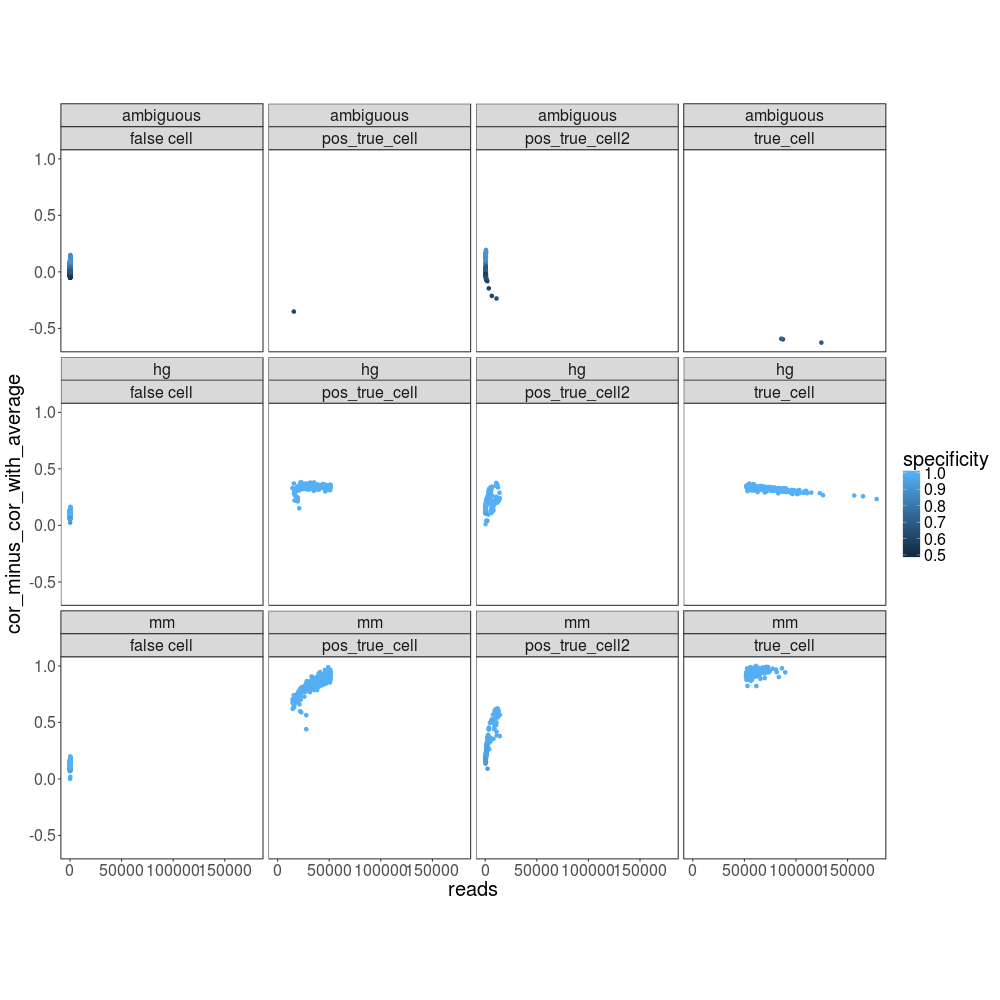

In [447]:
%%R -i df -w 1000 -h 1000
print(head(df))
p <- ggplot(df, aes(reads, cor_minus_cor_with_average, colour=specificity)) + geom_point() + my_theme +
facet_wrap(species ~ cell_type)
print(p)


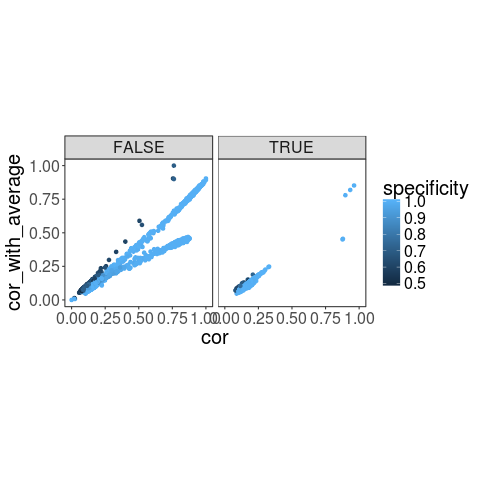

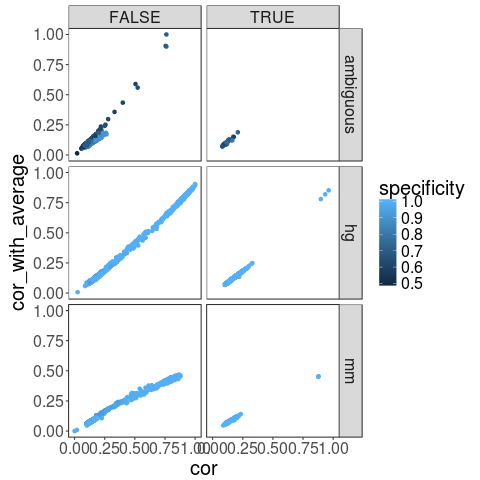

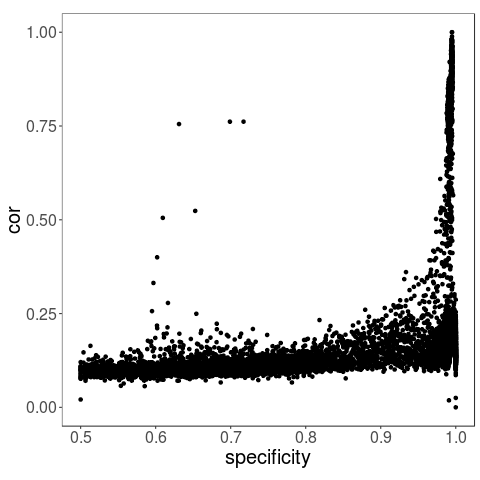

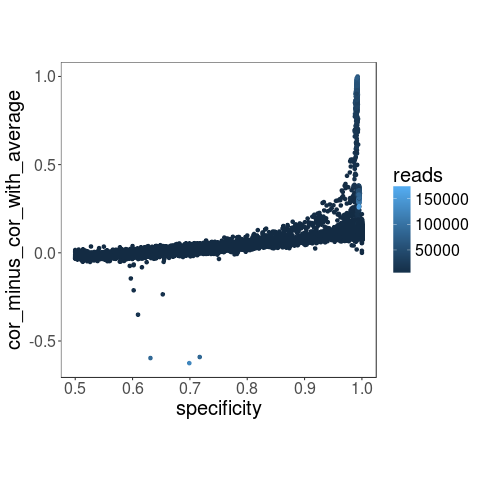

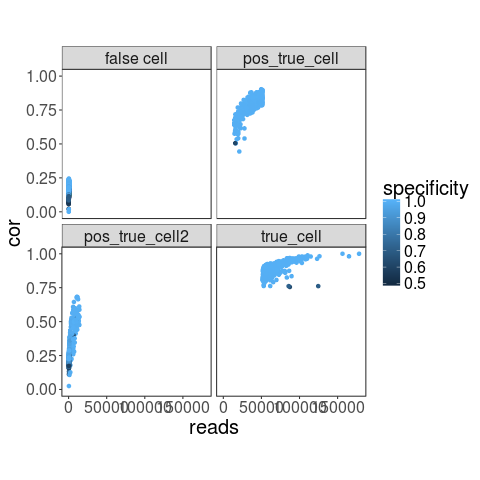

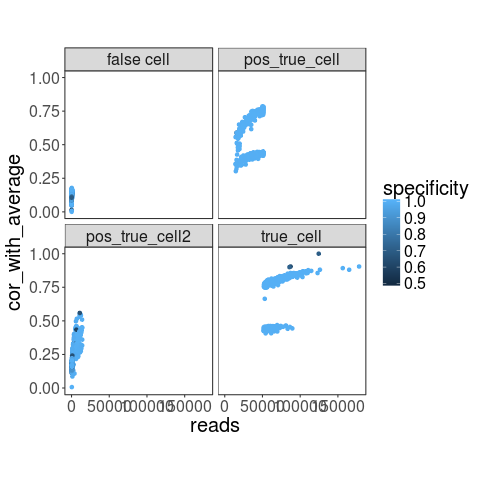

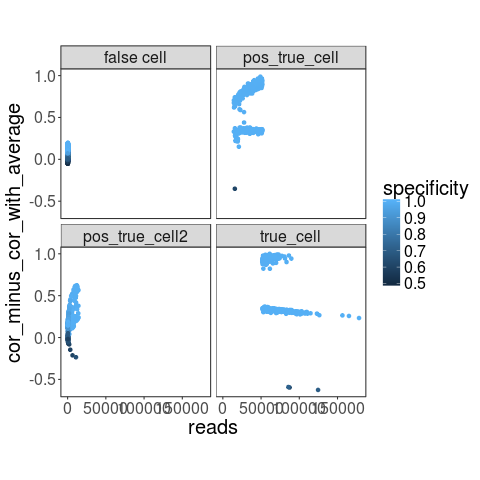

In [448]:
%%R -i df
p <- ggplot(df, aes(cor, cor_with_average, colour=specificity)) + geom_point() + my_theme +
facet_grid(.~error)
print(p)

p <- ggplot(df, aes(cor, cor_with_average, colour=specificity)) + geom_point() + my_theme +
facet_grid(species~error)
print(p)

p <- ggplot(df, aes(specificity, cor)) + geom_point() + my_theme
print(p)

p <- ggplot(df, aes(specificity, cor_minus_cor_with_average, colour=reads)) + geom_point() + my_theme
print(p)

p <- ggplot(df, aes(reads, cor, colour=specificity)) + geom_point() + my_theme +
facet_wrap(~cell_type)
print(p)

p <- ggplot(df, aes(reads, cor_with_average, colour=specificity)) + geom_point() + my_theme +
facet_wrap(~cell_type)
print(p)

p <- ggplot(df, aes(reads, cor_minus_cor_with_average, colour=specificity)) + geom_point() + my_theme +
facet_wrap(~cell_type)
print(p)


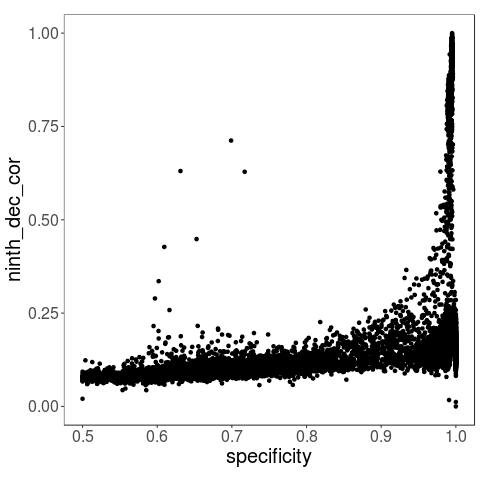

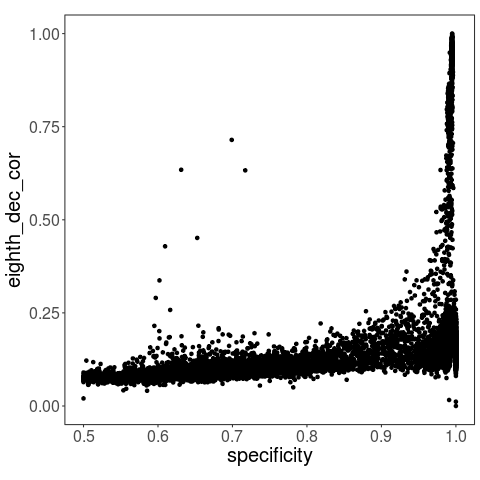

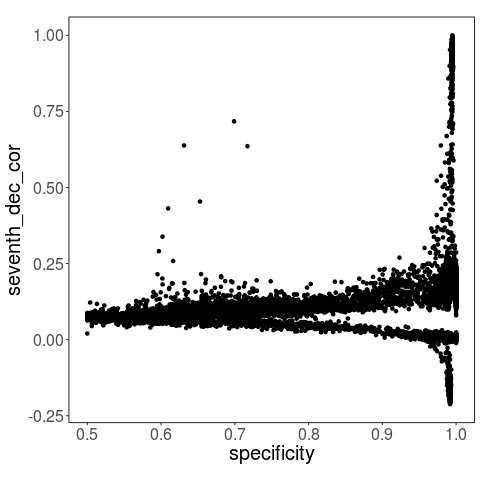

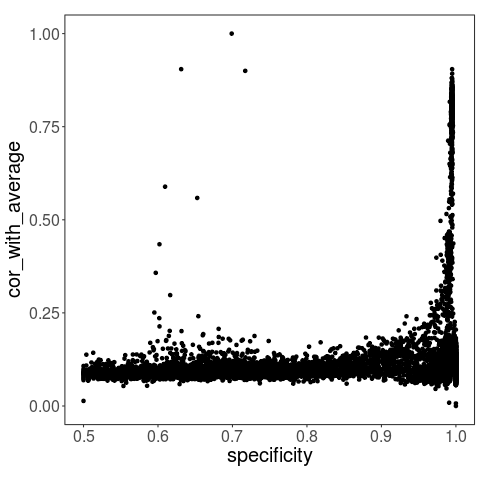

In [449]:
%%R
p <- ggplot(df, aes(specificity, ninth_dec_cor)) + geom_point() + my_theme
print(p)

p <- ggplot(df, aes(specificity, eighth_dec_cor)) + geom_point() + my_theme
print(p)

p <- ggplot(df, aes(specificity, seventh_dec_cor)) + geom_point() + my_theme
print(p)

p <- ggplot(df, aes(specificity, cor_with_average)) + geom_point() + my_theme
print(p)

Let's see how the cells separate on the first PCs. Note that we are not using all the metrics (see "use_metrics" variable)

In [594]:
use_metrics = ["assigned", "mt", "dup_rate", "ratio_mean_max", "mean_qual",
               "over_mean_exp", "cor", "cor_minus_cor_with_average"]

In [595]:
%%R -i df -i use_metrics

library(ggplot2)

my_theme <- theme_bw() + theme(text=element_text(size=20), panel.grid=element_blank(), aspect.ratio=1)

pca <- prcomp(t(df[,match(use_metrics,colnames(df))]))
projections <- data.frame(pca$rotation)
projections <- merge(projections, df, by="row.names")


Quick peek at the distribution of the correlation metrics

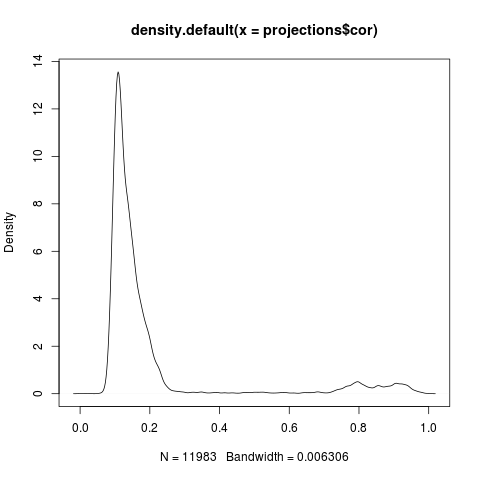

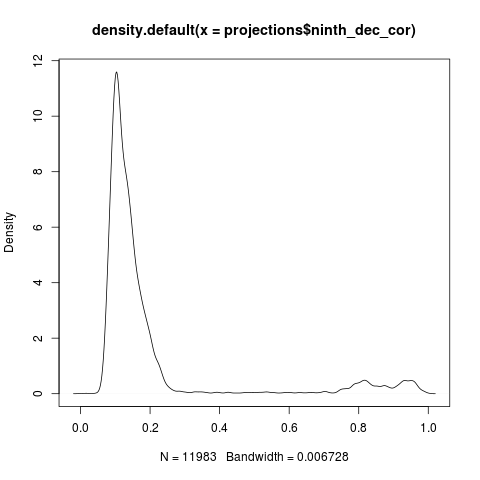

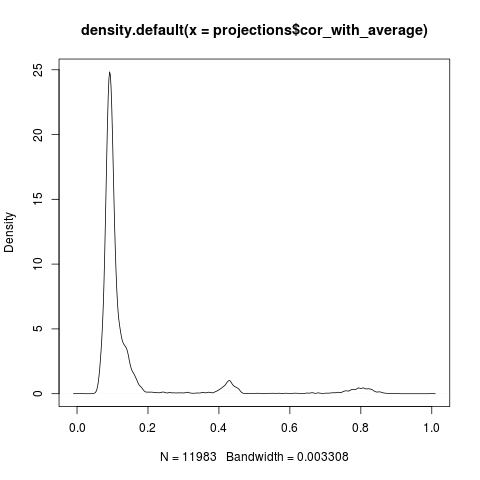

In [596]:
%%R
plot(density(projections$cor))
plot(density(projections$ninth_dec_cor))
plot(density(projections$cor_with_average))

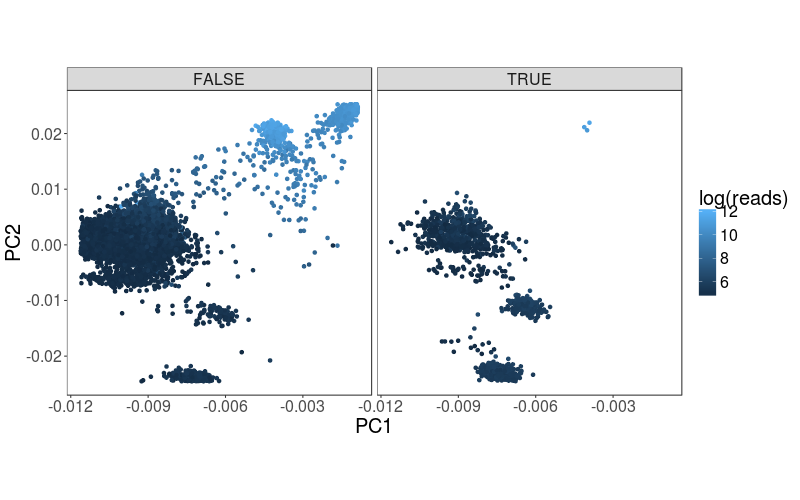

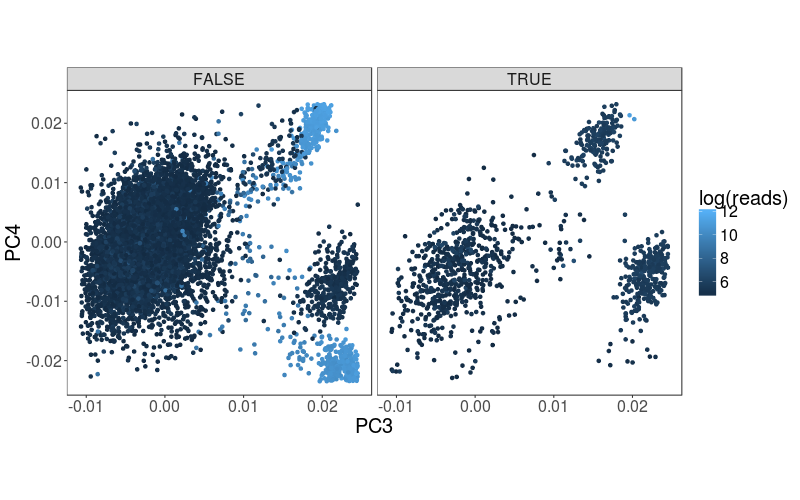

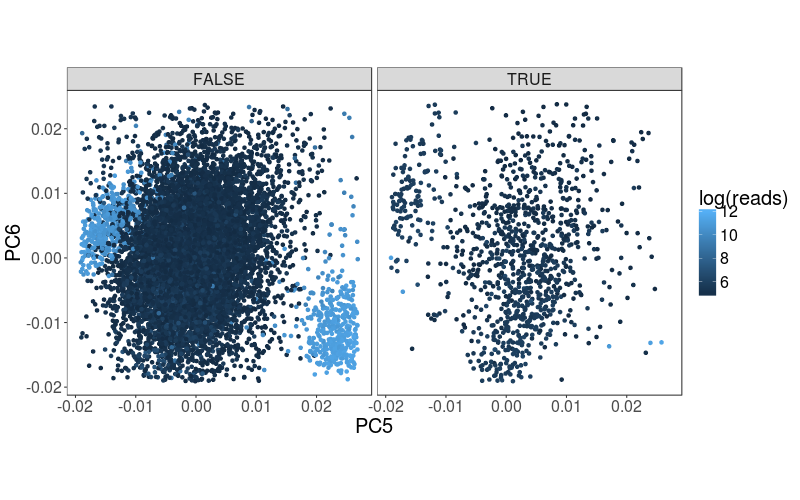

In [597]:
%%R -w 800 -h 500

printPCA <- function(projections, x="PC1", y="PC2", lim=T, colour_by=F, facet_by=F){
    p <- ggplot(projections, aes_string(x, y)) + geom_point() + my_theme
    
    if(lim){
    p <- p + xlim(c(quantile(projections[[x]], c(0.01, 0.99)))) +
        ylim(c(quantile(projections[[y]], c(0.01, 0.99))))
    }
    
    if(!missing(colour_by)){
        p <- p + aes_string(colour=colour_by)
    }
    
    if(!missing(facet_by)){
        projections$facet <- projections[[facet_by]]
        p <- p %+% projections + facet_wrap(~facet)
    }

    print(p)
}

printPCs <- function(projections, ...){
    printPCA(projections, ...)
    printPCA(projections, "PC3", "PC4", ...)
    printPCA(projections, "PC5", "PC6", ...)    
}

printPCs(projections, colour_by="log(reads)", facet_by="error")

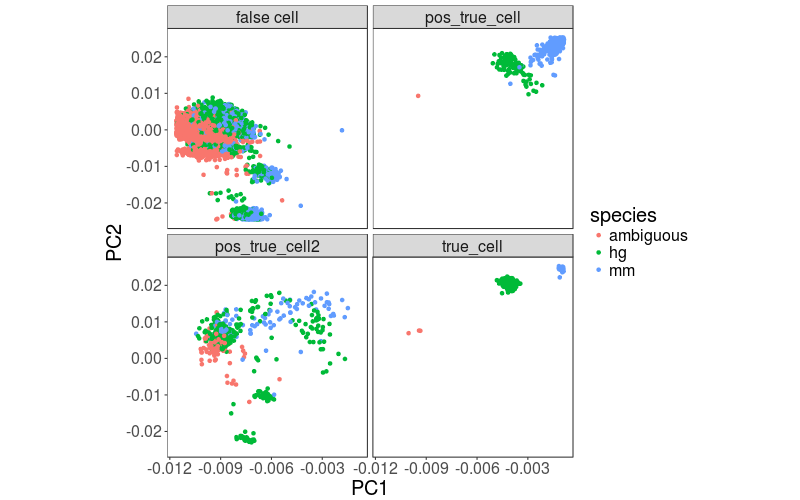

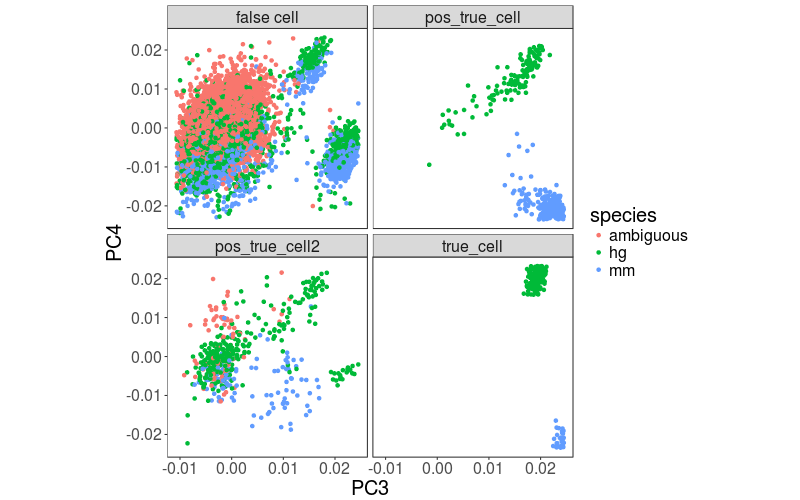

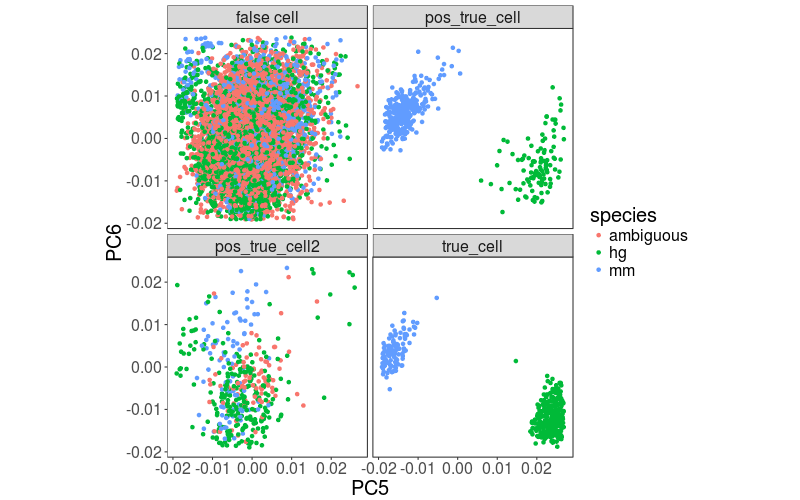

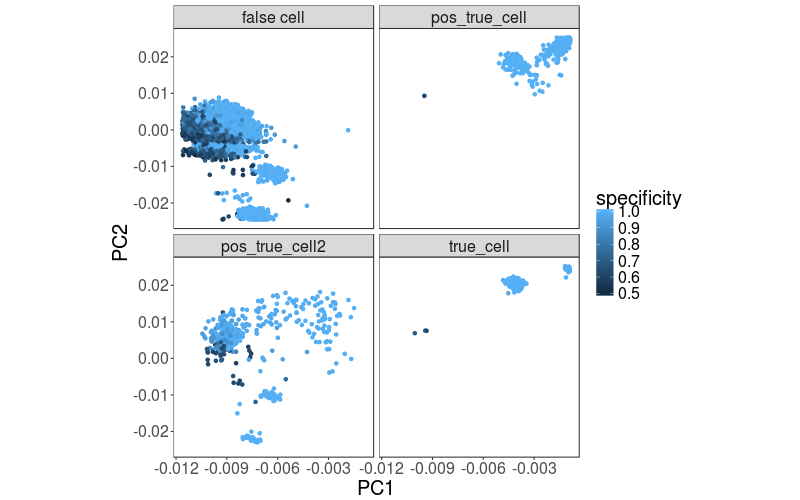

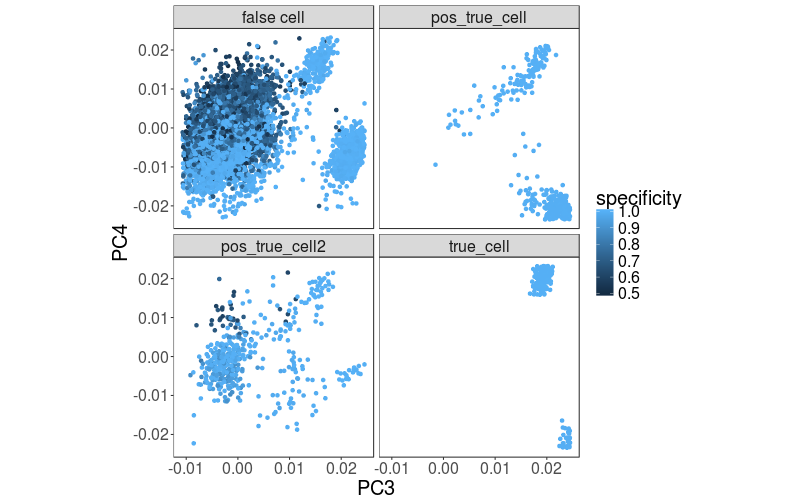

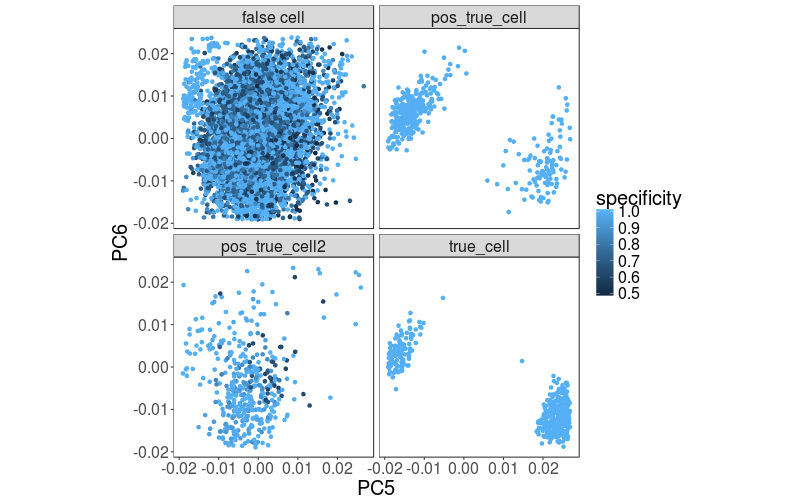

In [598]:
%%R -w 800 -h 500
printPCs(projections, colour_by="species", facet_by="cell_type")
printPCs(projections, colour_by="specificity", facet_by="cell_type")

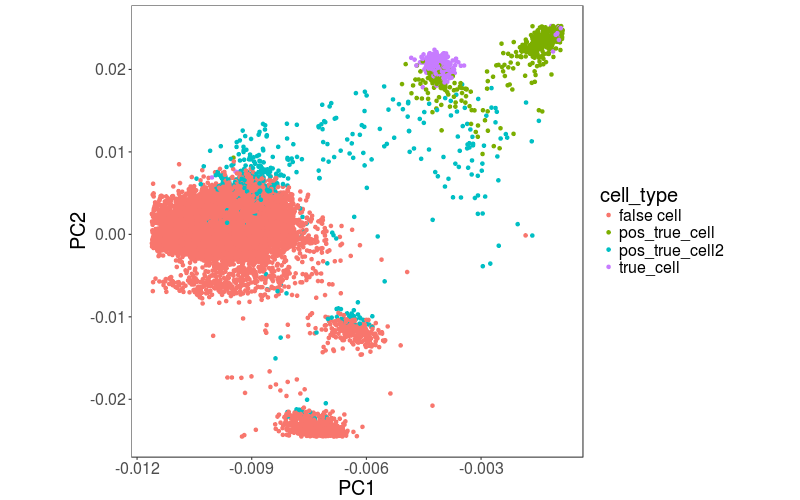

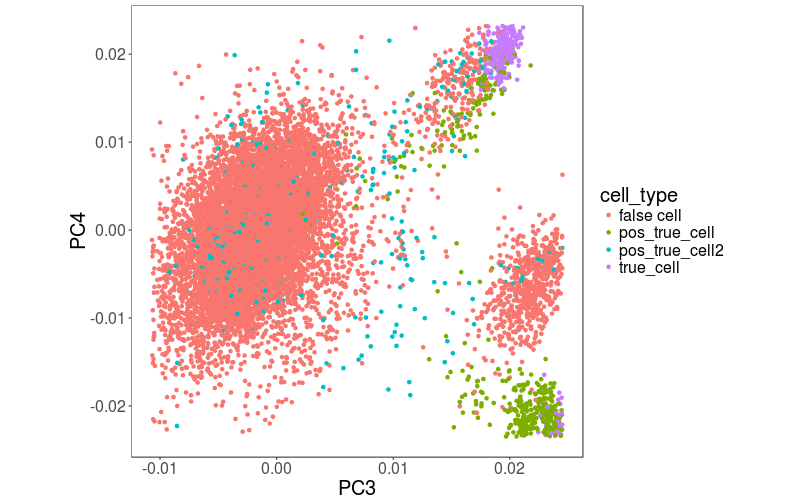

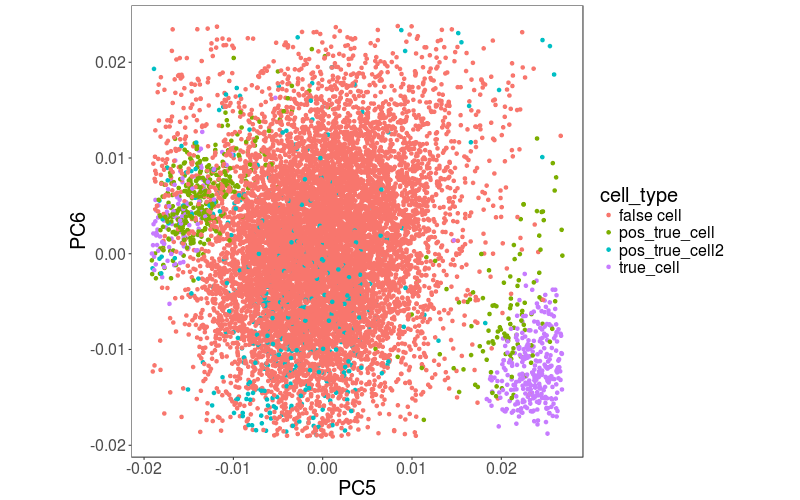

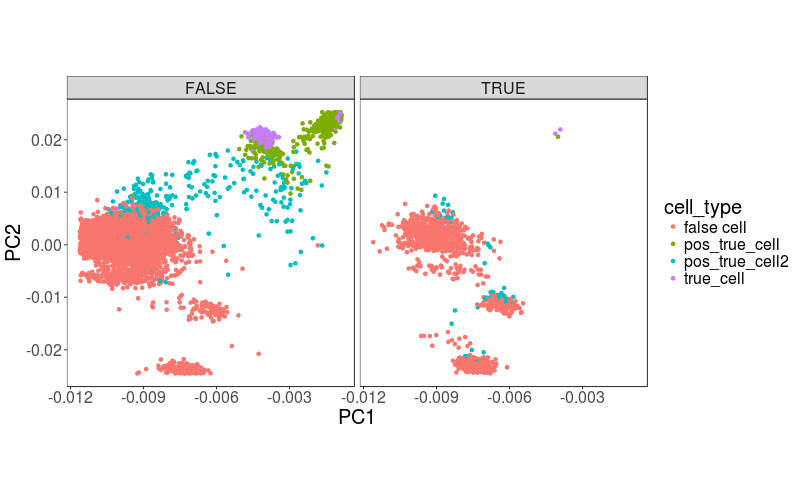

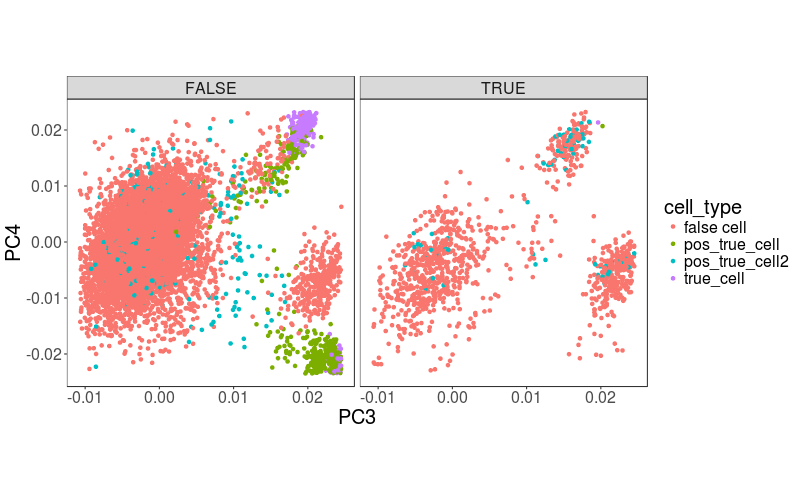

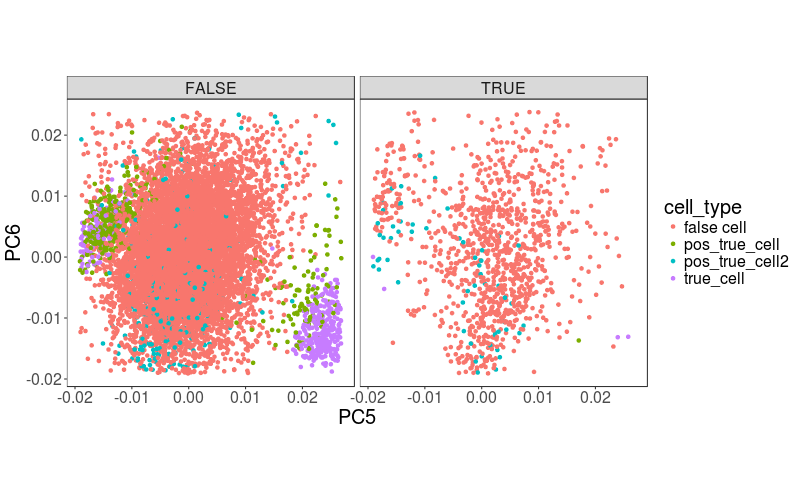

In [599]:
%%R -w 800 -h 500
printPCs(projections, colour_by="cell_type")
printPCs(projections, colour_by="cell_type", facet_by="error")

In [600]:
# Split-out validation dataset
ml_df = df[[x in ["true_cell", "false cell"] for x in df['cell_type']]]
     
X = ml_df.loc[:,use_metrics].values
Y = ml_df['cell_type'].values
validation_size = 0.20
seed = 0
X_train, X_validation, Y_train, Y_validation = model_selection.train_test_split(
    X, Y, test_size=validation_size, random_state=seed)

scoring = 'accuracy'

Test out different ML methods. Note that we're not doing any optmisation of parameters here for e.g KNN, SVM

In [601]:
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))

results = []
names = []
for name, model in models:
    print(name, model)
    kfold = model_selection.KFold(n_splits=5, random_state=seed)
    cv_results = model_selection.cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
LR: 0.999659 (0.000455)
LDA LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001)
LDA: 1.000000 (0.000000)
KNN KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')
KNN: 0.999659 (0.000455)
CART DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')
CART: 1.000000 (0.000000)
NB G

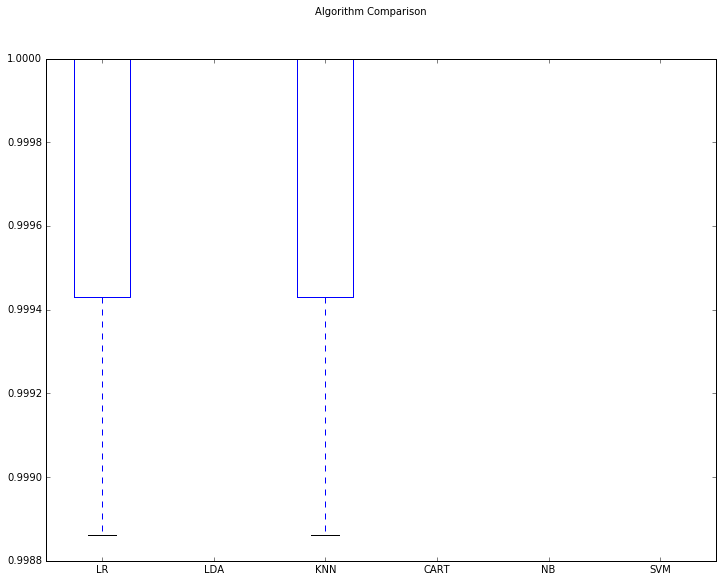

In [602]:
# Compare Algorithms
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

So it turns out all the methods can perfectly separate the true and false cells! Let's proceed with Gaussian NB as the output is a probability for the classification making it easier to interpret. Let's check the impact of using the number of cells in each class as the priors.

In [603]:
def predictCellType(df, ml):
    X_full = df.loc[:,use_metrics].values
    predictions = ml.predict(X_full)
    probs = [x[1] for x in ml.predict_proba(X_full)]
    print(df['cell_type'].value_counts())
    print(confusion_matrix(df['cell_type'], predictions))
    print("\n\n")
    return(predictions, probs)

In [604]:
def testNBPriors(prior_values=False):
    if prior_values:
        ml = GaussianNB(prior_values)
    else:
        ml = GaussianNB()
    ml.fit(X_train, Y_train)
    predictions = ml.predict(X_validation)
    x = predictCellType(df[[x not in ["true_cell", "false cell"] for x in df['cell_type']]], ml)
    predictions, probs = predictCellType(df, ml)
    df['pred'] = predictions
    df['prob'] = probs
    return(df)

In [605]:
cell_type_counts = df['cell_type'].value_counts()
prob_true = cell_type_counts['true_cell'] / (cell_type_counts['true_cell'] + cell_type_counts['false cell'])

df_NB_unequal1 = testNBPriors([prob_true, 1-prob_true])
df_NB = testNBPriors()

pos_true_cell     500
pos_true_cell2    500
Name: cell_type, dtype: int64
[[  0   0   0   0]
 [ 16   0   0 484]
 [455   0   0  45]
 [  0   0   0   0]]



false cell        10483
pos_true_cell2      500
pos_true_cell       500
true_cell           500
Name: cell_type, dtype: int64
[[10483     0     0     0]
 [   16     0     0   484]
 [  455     0     0    45]
 [    0     0     0   500]]



pos_true_cell     500
pos_true_cell2    500
Name: cell_type, dtype: int64
[[  0   0   0   0]
 [ 16   0   0 484]
 [456   0   0  44]
 [  0   0   0   0]]



false cell        10483
pos_true_cell2      500
pos_true_cell       500
true_cell           500
Name: cell_type, dtype: int64
[[10483     0     0     0]
 [   16     0     0   484]
 [  456     0     0    44]
 [    0     0     0   500]]





OK so ...

Now let's replot the PCs and see how the classification probabilities relate to the cell type and metrics.

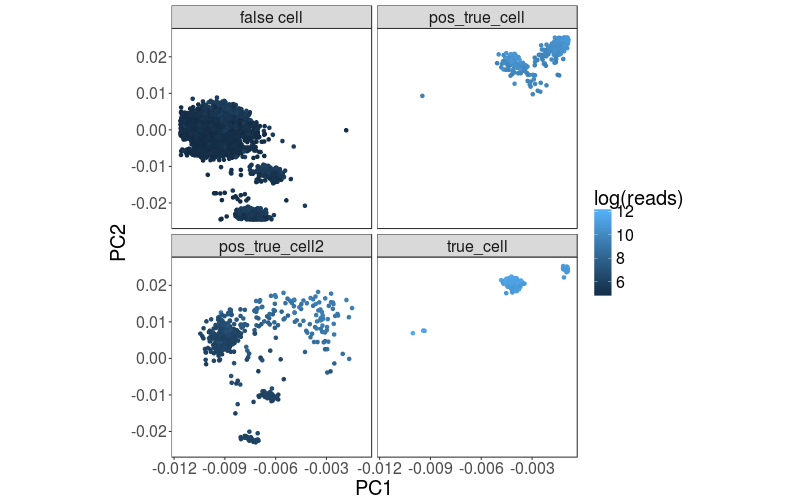

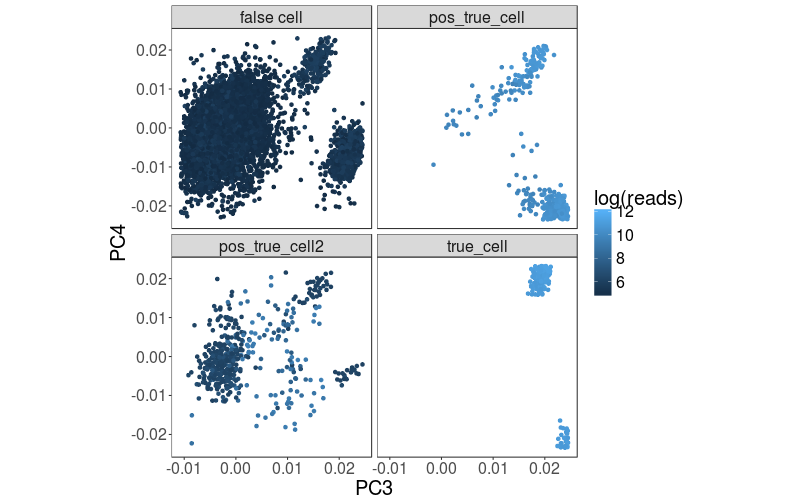

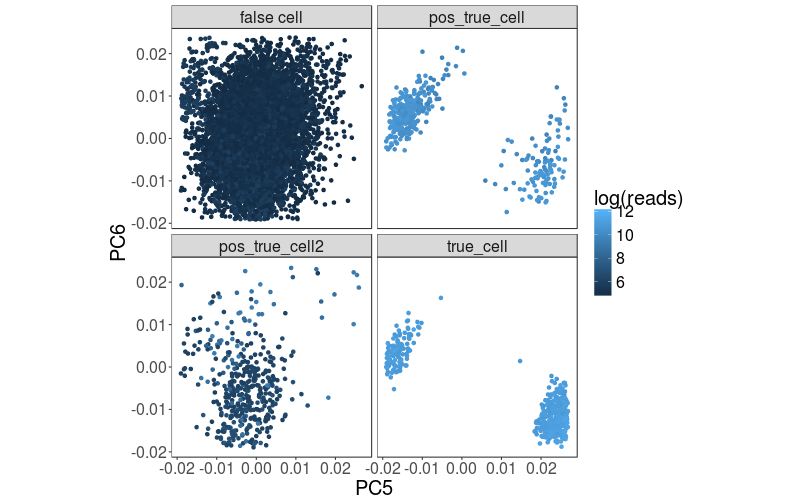

In [606]:
%%R -w 800 -h 500
printPCs(projections, colour_by="log(reads)", facet_by="cell_type")

In [607]:
# Make predictions on validation dataset
ml = KNeighborsClassifier(n_neighbors=10)
ml = GaussianNB([prob_true, 1-prob_true])
ml.fit(X_train, Y_train)
predictions = ml.predict(X_validation)
print(accuracy_score(Y_validation, predictions))
print(confusion_matrix(Y_validation, predictions))
print(classification_report(Y_validation, predictions))

1.0
[[2086    0]
 [   0  111]]
             precision    recall  f1-score   support

 false cell       1.00      1.00      1.00      2086
  true_cell       1.00      1.00      1.00       111

avg / total       1.00      1.00      1.00      2197



In [608]:
print(ml)

GaussianNB(priors=[0.045524902121460438, 0.95447509787853957])


In [609]:
x = predictCellType(df[[x not in ["true_cell", "false cell"] for x in df['cell_type']]], ml)
predictions, probs = predictCellType(df, ml)
df['pred'] = predictions
df['prob'] = probs

pos_true_cell     500
pos_true_cell2    500
Name: cell_type, dtype: int64
[[  0   0   0   0]
 [ 16   0   0 484]
 [455   0   0  45]
 [  0   0   0   0]]



false cell        10483
pos_true_cell2      500
pos_true_cell       500
true_cell           500
Name: cell_type, dtype: int64
[[10483     0     0     0]
 [   16     0     0   484]
 [  455     0     0    45]
 [    0     0     0   500]]





In [610]:
%%R -i df
print(dim(df))

print(head(df[,match(use_metrics, colnames(df))]))
pca <- prcomp(t(df[,match(use_metrics, colnames(df))]))
print(round(pca$sdev^2/sum(pca$sdev^2),2))
print(pca$x)
projections <- data.frame(pca$rotation)
projections <- merge(projections, df, by="row.names")
print(head(projections))


[1] 11983    23
                  assigned         mt  dup_rate ratio_mean_max mean_qual
CGGCACAGCTGAACGT 0.6554622 0.03616960 0.5126050      0.4482759 0.2049104
CATTCGCTCGTTACAG 0.8272727 0.00000000 0.4454545      0.2983607 0.2061780
AGCTCTCTCACTGGGC 0.6092544 0.04992725 0.5365197      0.2190868 0.1571772
GAAAGCAGTCAAGCGA 0.6899225 0.00000000 0.4728682      0.4362745 0.1669535
CTCATTAAGAGACTAT 0.6962025 0.01362083 0.4430380      0.4166667 0.1584519
ATTTCTGCAGACAAAT 0.8015267 0.22999449 0.3358779      0.4022989 0.1106705
                 over_mean_exp        cor cor_minus_cor_with_average
CGGCACAGCTGAACGT     0.5345912 0.14379792                0.100988236
CATTCGCTCGTTACAG     0.6845238 0.10848264                0.031068084
AGCTCTCTCACTGGGC     0.2823538 0.82586841                0.315392731
GAAAGCAGTCAAGCGA     0.5820106 0.14650842                0.099939123
CTCATTAAGAGACTAT     0.3488372 0.09511542                0.002817323
ATTTCTGCAGACAAAT     0.3755869 0.11791419               -0.

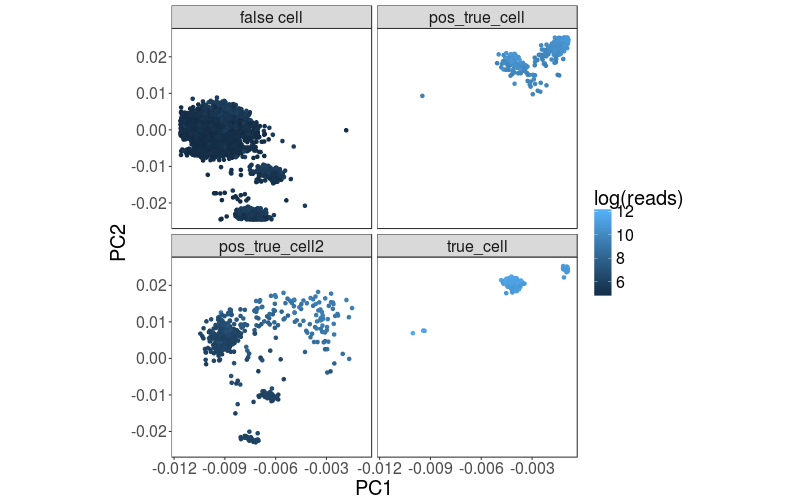

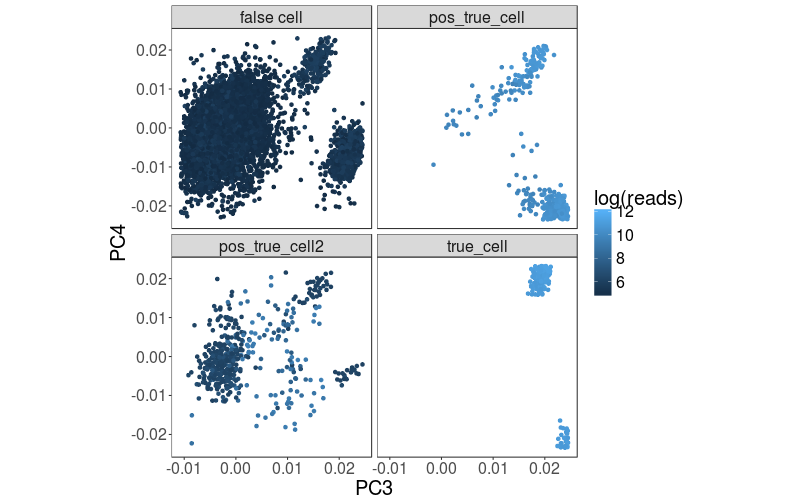

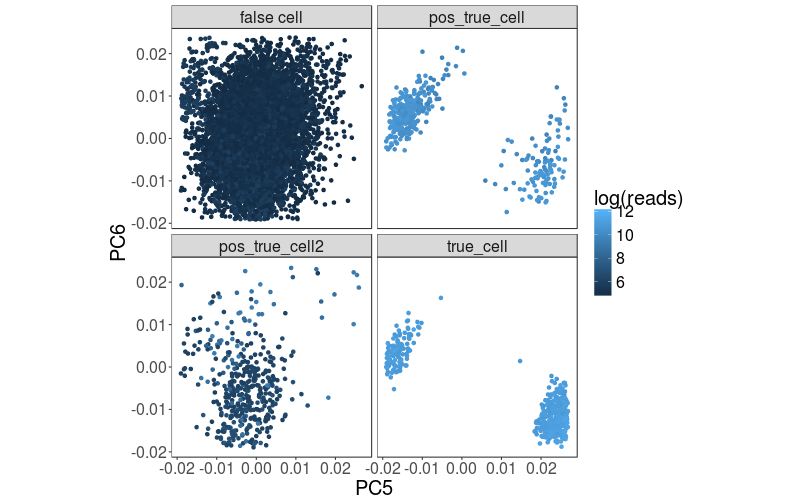

In [611]:
%%R -w 800 -h 500
printPCs(projections, colour_by="log(reads)", facet_by="cell_type")

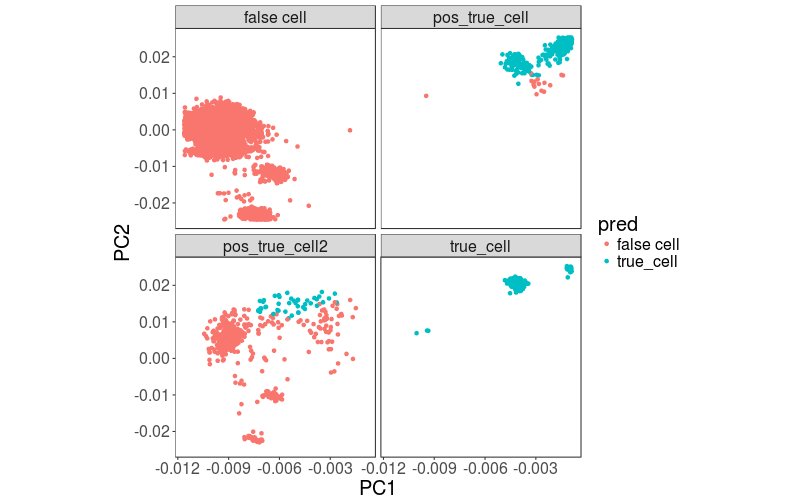

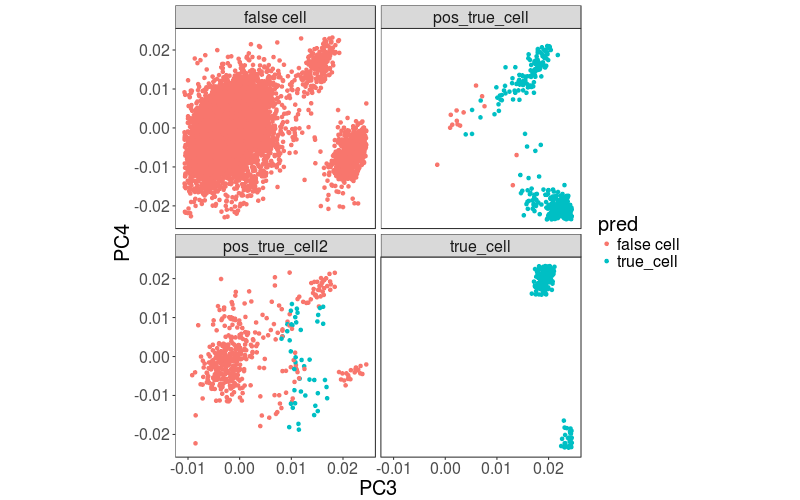

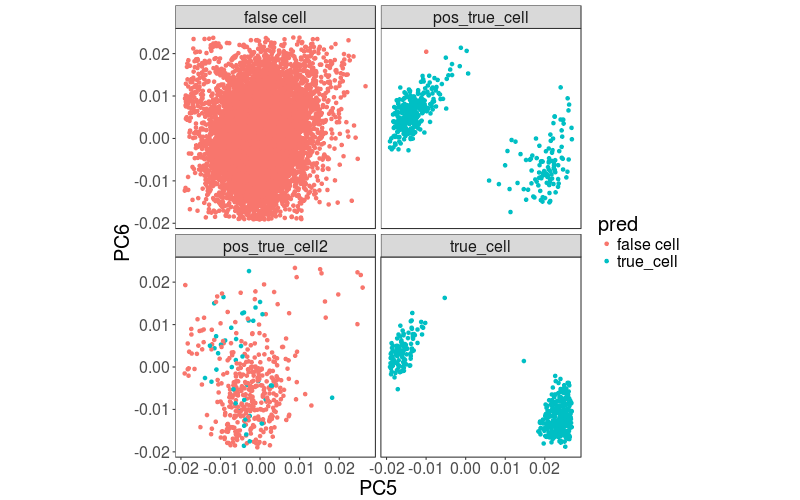

In [612]:
%%R -w 800 -h 500
printPCs(projections, colour_by="pred", facet_by="cell_type")

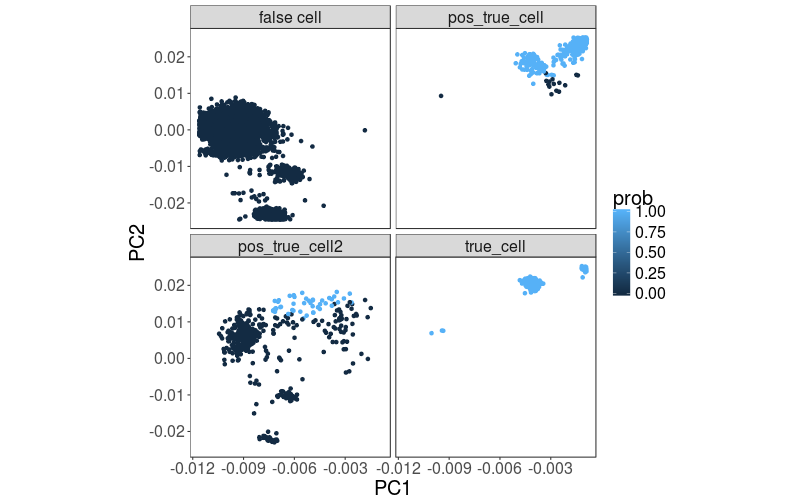

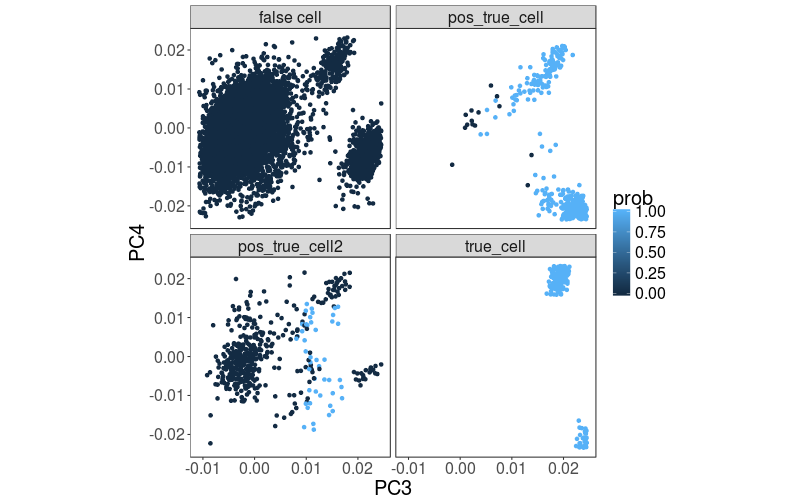

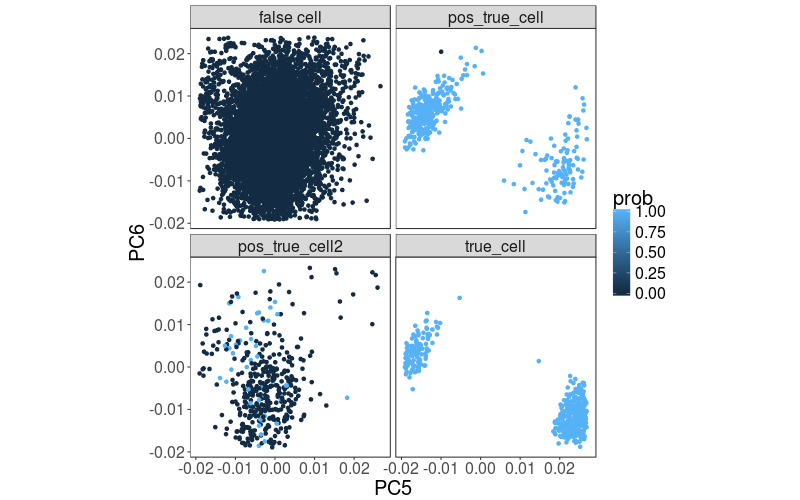

In [613]:
%%R -w 800 -h 500
printPCs(projections, colour_by="prob", facet_by="cell_type")

In [614]:
%%R
print(rnorm(1))

[1] -1.617578


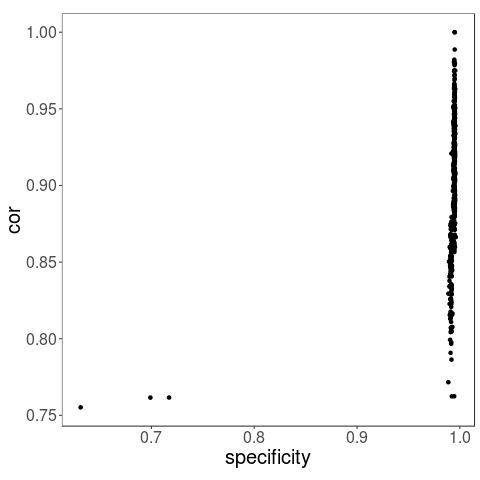

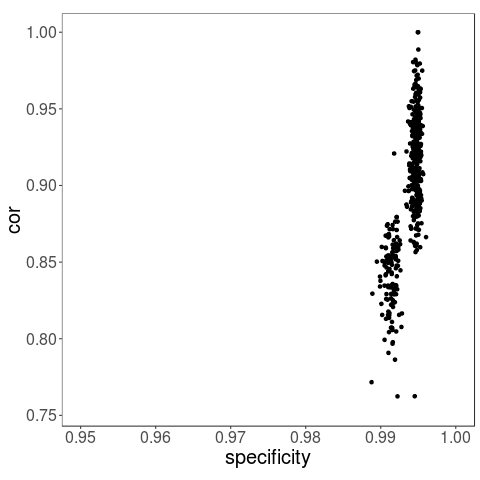

In [615]:
%%R

p <- ggplot(df[df$cell_type=="true_cell",], aes(specificity, cor)) + geom_point() + my_theme
print(p)

p <- ggplot(df[df$cell_type=="true_cell",], aes(specificity, cor)) + geom_point() + my_theme +
xlim(0.95, 1)
print(p)


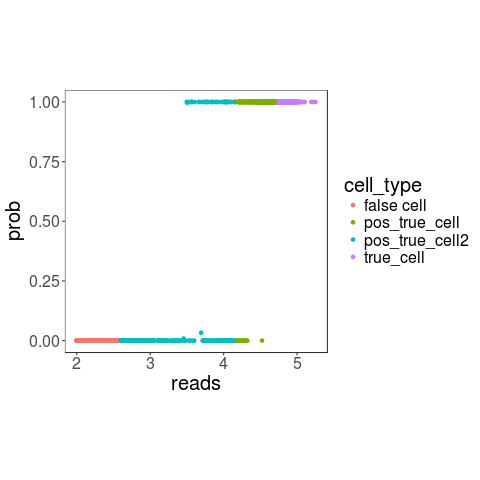

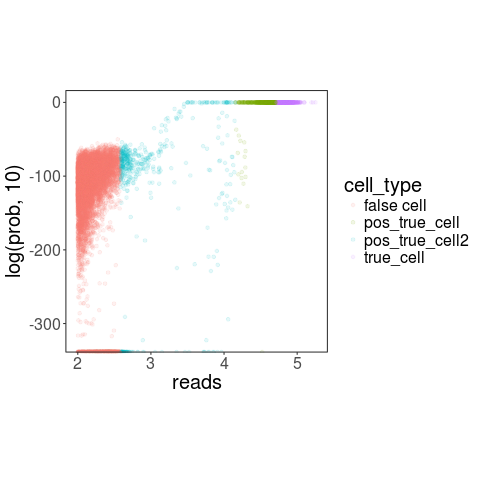

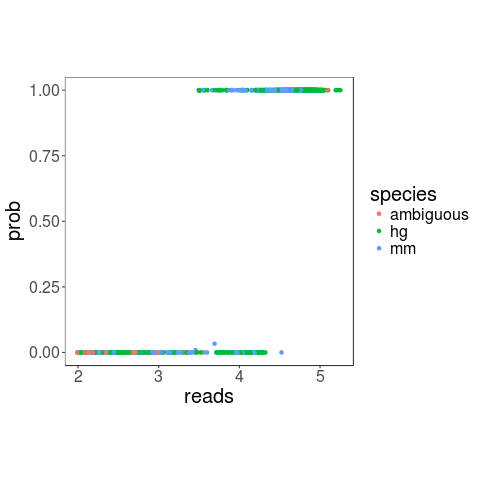

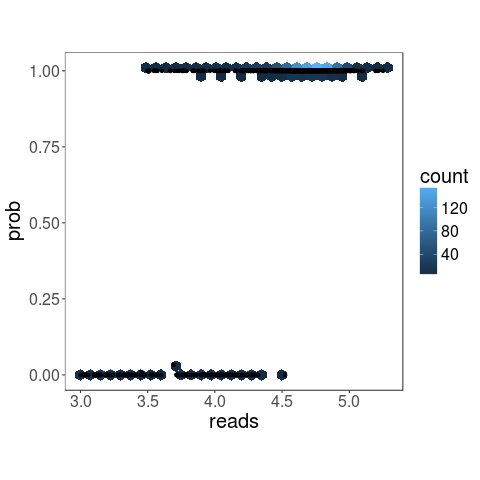

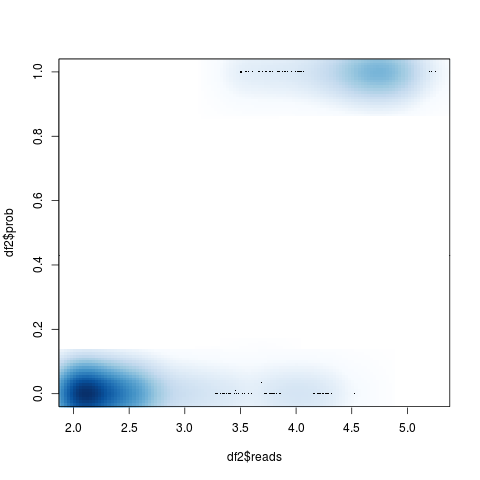

In [627]:
%%R
library(reshape2)
df2 = df
df2$reads = log(df2$reads,10)

p <- ggplot(df2, aes(reads, prob, colour=cell_type)) +
geom_point() + my_theme
print(p)

p <- ggplot(df2, aes(reads, log(prob,10), colour=cell_type)) +
geom_point(alpha=0.1) + my_theme
print(p)


p <- ggplot(df2, aes(reads, prob, colour=species)) +
geom_point() + my_theme
print(p)

p <- ggplot(df2[df2$reads>3,], aes(reads, y=prob)) +
geom_hex() + geom_point()  + 
my_theme
print(p)

smoothScatter(df2$reads, df2$prob)

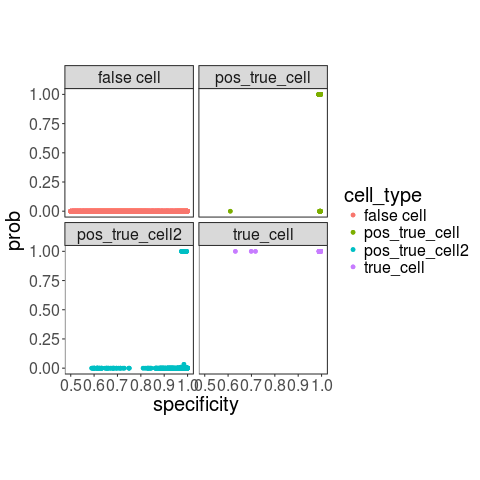

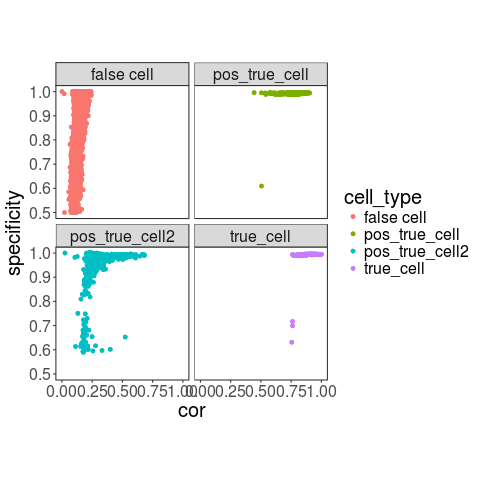

In [617]:
%%R

p <- ggplot(df2, aes(specificity, prob, colour=cell_type)) +
facet_wrap(~cell_type) +
geom_point() + geom_point() + my_theme
print(p)

p <- ggplot(df2, aes(cor, specificity, colour=cell_type)) +
facet_wrap(~cell_type) +
geom_point() + geom_point() + my_theme
print(p)

In [618]:
x = predictCellType(df[[x not in ["true_cell", "false_cell"] for x in df['cell_type']]], ml)
x = predictCellType(df, ml)

false cell        10483
pos_true_cell2      500
pos_true_cell       500
Name: cell_type, dtype: int64
[[10483     0     0     0]
 [   16     0     0   484]
 [  455     0     0    45]
 [    0     0     0     0]]



false cell        10483
pos_true_cell2      500
pos_true_cell       500
true_cell           500
Name: cell_type, dtype: int64
[[10483     0     0     0]
 [   16     0     0   484]
 [  455     0     0    45]
 [    0     0     0   500]]





/home/FILESERVER5/proteomics/tss38/anaconda3/lib/python3.5/site-packages/rpy2-2.8.5-py3.5-linux-x86_64.egg/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Using cell_type, error, pred, species as id variables

  warnings.warn(x, RRuntimeWarning)
/home/FILESERVER5/proteomics/tss38/anaconda3/lib/python3.5/site-packages/rpy2-2.8.5-py3.5-linux-x86_64.egg/rpy2/rinterface/__init__.py:186: RRuntimeWarning: notch went outside hinges. Try setting notch=FALSE.

  warnings.warn(x, RRuntimeWarning)


      cell_type error       pred   species variable    value
1    false cell FALSE false cell        hg    reads 2.201397
2    false cell FALSE false cell ambiguous    reads 2.127105
3 pos_true_cell FALSE  true_cell        hg    reads 4.691152
4    false cell  TRUE false cell        hg    reads 2.178977
5    false cell FALSE false cell ambiguous    reads 2.041393
6    false cell FALSE false cell ambiguous    reads 2.201397


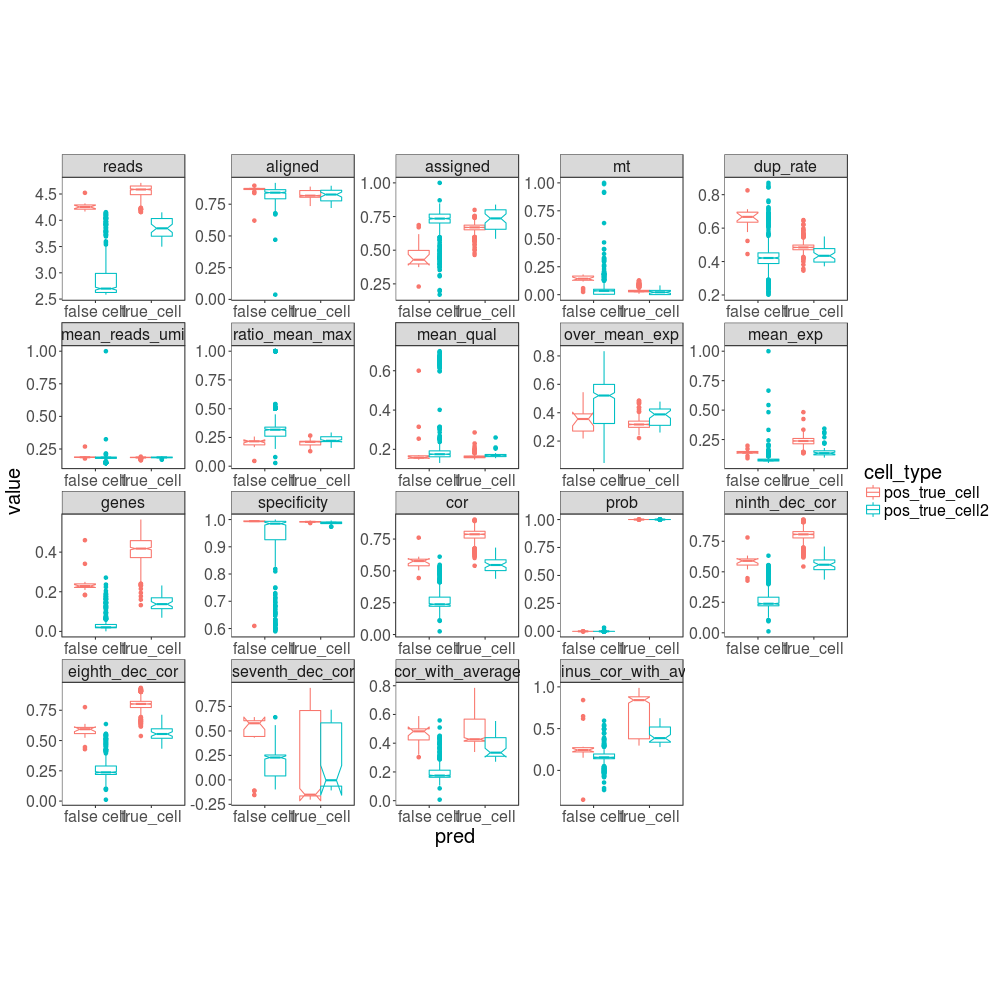

In [619]:
%%R -w 1000 -h 1000
df2 <- df2[df2$mean_reads_umi < 3,]
m_df <- melt(df2)
print(head(m_df))
p <- ggplot(m_df[m_df$cell_type %in% c("pos_true_cell", "pos_true_cell2"),],
                 aes(pred, value, colour=cell_type)) +
geom_boxplot(notch=T) + my_theme + facet_wrap(~variable, scales="free")
print(p)

In [628]:
exp_arrays = {}
all_true_cells = true_cells.tolist()
all_true_cells.extend(pos_true_cells.tolist())
all_true_cells.extend(pos_true_cells2.tolist())
for cell in all_true_cells:
    exp_array = []
    for gene in all_genes:
        if gene in cell_umi_counts[cell]:
            exp_array.append(len(cell_umi_counts[cell][gene]))
        else:
            exp_array.append(0)

    exp_arrays[cell] = exp_array
    
exp_df = pd.DataFrame.from_records(exp_arrays, index=all_genes)

In [629]:
for cell in all_true_cells:
    exp_array = []
    for gene in all_genes:
        if len(cell_umi_counts[cell][gene]) == 0:
            del cell_umi_counts[cell][gene]

In [630]:
exp_df = pd.DataFrame.from_records(exp_arrays, index=all_genes)
exp_df = exp_df.div(exp_df.sum(axis=0), axis=1)
print(exp_df.shape)
exp_df['mean_exp'] = exp_df.mean(axis=1)
exp_df.sort_values("mean_exp", inplace=True, ascending=False)
exp_df.drop("mean_exp", axis=1)
exp_df = exp_df.ix[0:1000,]
print(exp_df.shape)
print(exp_df.head())

(28368, 1500)
(1000, 1501)
                    AAACGGGAGAGTGAGA  AAACGGGAGCGTTTAC  AAACGGGCACATTTCT  \
ENSMUSG00000068220          0.000043          0.000000          0.000102   
ENSG00000198938             0.004500          0.000000          0.004931   
ENSG00000198712             0.003557          0.000000          0.004726   
ENSG00000198804             0.001800          0.000000          0.005646   
ENSG00000198034             0.010714          0.007273          0.012084   

                    AAAGATGAGACGACGT  AAAGATGAGCATCATC  AAAGATGCAGCGTAAG  \
ENSMUSG00000068220          0.000095          0.000054          0.000000   
ENSG00000198938             0.004601          0.006023          0.007223   
ENSG00000198712             0.005704          0.007041          0.006817   
ENSG00000198804             0.004916          0.009156          0.007426   
ENSG00000198034             0.010368          0.010066          0.011565   

                    AAAGATGCATCCAACA  AAAGCAAAGCTAGCCC  AAA

In [631]:
%%R -i exp_df
print(exp_df[1:5,1:5])
print(head(df))

                   AAACGGGAGAGTGAGA AAACGGGAGCGTTTAC AAACGGGCACATTTCT
ENSMUSG00000068220     4.285408e-05      0.000000000     0.0001021868
ENSG00000198938        4.499679e-03      0.000000000     0.0049305130
ENSG00000198712        3.556889e-03      0.000000000     0.0047261394
ENSG00000198804        1.799871e-03      0.000000000     0.0056458206
ENSG00000198034        1.071352e-02      0.007272727     0.0120835888
                   AAAGATGAGACGACGT AAAGATGAGCATCATC
ENSMUSG00000068220     9.453881e-05     5.354179e-05
ENSG00000198938        4.600889e-03     6.023451e-03
ENSG00000198712        5.703841e-03     7.040745e-03
ENSG00000198804        4.916018e-03     9.155646e-03
ENSG00000198034        1.036776e-02     1.006586e-02
                 reads   aligned  assigned         mt  dup_rate mean_reads_umi
CGGCACAGCTGAACGT   159 0.8013468 0.6554622 0.03616960 0.5126050      0.1921182
CATTCGCTCGTTACAG   134 0.8789386 0.8272727 0.00000000 0.4454545      0.2131148
AGCTCTCTCACTGGGC 49108 0.

In [632]:
%%R
pred_true_cells = rownames(df[df$pred == "true_cell",])

#pca <- prcomp(log(exp_df[,colnames(exp_df) %in% pred_true_cells]+1), scale=T)
pca <- prcomp(exp_df, scale=T)
var_explained <- pca$sdev^2/(sum(pca$sdev^2))
print(var_explained[0:10])


 [1] 0.426711551 0.288562475 0.042660837 0.019409950 0.008888377 0.005750146
 [7] 0.004198420 0.003336767 0.003053174 0.002813265


In [633]:
%%R -w 700 -h 700

#print(head(projections))

plotPCA <- function(pca, df, x="PC1", y="PC2", colour="reads"){
    projections <- pca$rotation[,1:20]
    projections <- merge(projections, df, by="row.names")
    var_explained <- pca$sdev^2/(sum(pca$sdev^2))
    p <- ggplot(projections, aes_string(x, y, colour=colour)) +
    geom_point() + my_theme
    
    return(p)

}

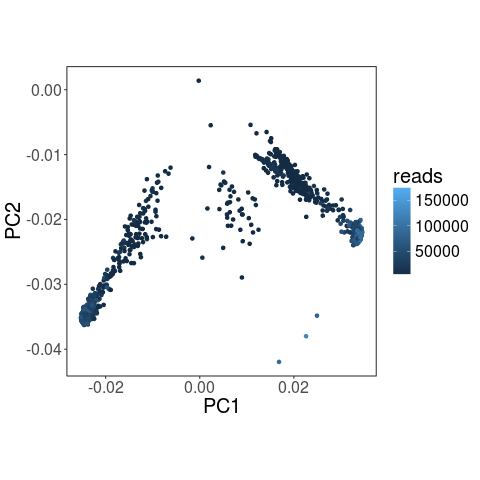

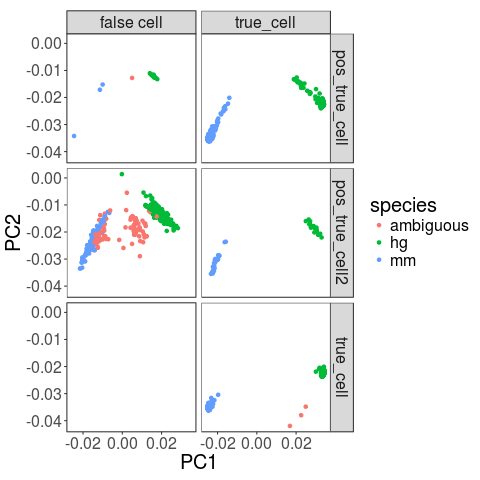

In [634]:
%%R

p <- plotPCA(pca, df)
print(p)

p2 <- plotPCA(pca, df, colour="species") + facet_grid(cell_type ~ pred)
print(p2)



In [635]:
%%R
print(table((df$prob > 0.01 & df$prob < 0.99)))
plot(density((df$prob[(df$prob > 0.01 & df$prob < 0.99)])))
plot(density(log(df$prob)))


FALSE  TRUE 
11982     1
Error in density.default((df$prob[(df$prob > 0.01 & df$prob < 0.99)])) : 
  need at least 2 points to select a bandwidth automatically


/home/FILESERVER5/proteomics/tss38/anaconda3/lib/python3.5/site-packages/rpy2-2.8.5-py3.5-linux-x86_64.egg/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Error in density.default((df$prob[(df$prob > 0.01 & df$prob < 0.99)])) : 
  need at least 2 points to select a bandwidth automatically

  warnings.warn(x, RRuntimeWarning)
/home/FILESERVER5/proteomics/tss38/anaconda3/lib/python3.5/site-packages/rpy2-2.8.5-py3.5-linux-x86_64.egg/rpy2/rinterface/__init__.py:186: RRuntimeWarning: In addition: 
  warnings.warn(x, RRuntimeWarning)
/home/FILESERVER5/proteomics/tss38/anaconda3/lib/python3.5/site-packages/rpy2-2.8.5-py3.5-linux-x86_64.egg/rpy2/rinterface/__init__.py:186: RRuntimeWarning: There were 28 warnings (use warnings() to see them)
  warnings.warn(x, RRuntimeWarning)
/home/FILESERVER5/proteomics/tss38/anaconda3/lib/python3.5/site-packages/rpy2-2.8.5-py3.5-linux-x86_64.egg/rpy2/rinterface/__init__.py:186: RRuntimeWarning: 

  warnings.warn(x, RRuntimeWarning)


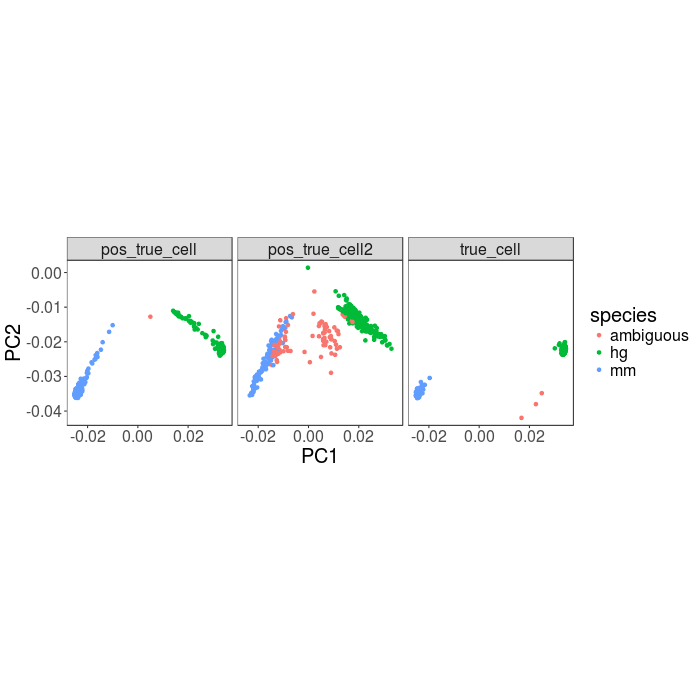

In [636]:
%%R -w 700 -h 700
p3 <- plotPCA(pca, df, colour="species") + facet_grid(.~cell_type)
print(p3)



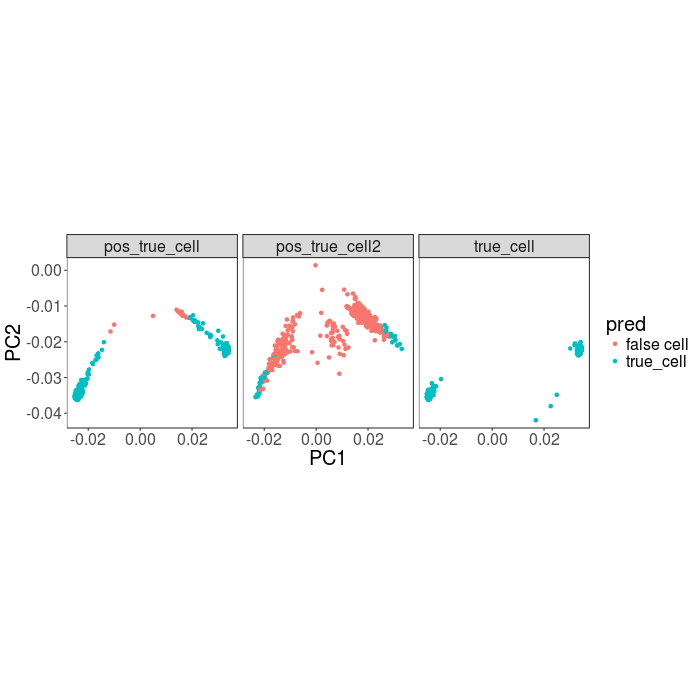

In [637]:
%%R -w 700 -h 700
p3 <- plotPCA(pca, df, colour="pred") + facet_grid(.~cell_type)
print(p3)

